# Training

## Setup

In [1]:
!pip install keras kimm -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3


In [2]:
%cd ../../

/


In [3]:
# set seed
seed = 42

# set n train and test images
n_train_images = 4000
n_test_images = 300

# set batch size
batch_size = 16

# set num classes
num_classes = 5

# set class names
class_names = ['tiger', 'lynx', 'bear', 'deer', 'bird']

# define paths to train and test images
images_input_dir = 'kaggle/input/preprocess-images/images'
images_sampled_dir = 'images'
!mkdir -p "$images_sampled_dir"
train_dir = images_input_dir + '/train'
train_dir_sampled = images_sampled_dir + '/train_sampled'
test_dir = images_input_dir + '/test'
test_dir_sampled = images_sampled_dir + '/test_sampled'
test2_dir = images_input_dir + '/test2'

# define path to model dir
model_dir = 'kaggle/working/model'
!mkdir -p "$model_dir"
model_path = model_dir + '/model.keras'
model_constructor = 'EfficientNetV2M'

# define path to media dir
media_dir = 'kaggle/working/media'
!mkdir -p "$media_dir"

In [4]:
import os
import time
import shutil
import random
import numpy as np

import keras
from keras import layers, optimizers, losses, callbacks, saving
import kimm
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import wandb
from kaggle_secrets import UserSecretsClient

In [5]:
def sample_images(source_dir, target_dir, samples_per_class, seed=42):
    """
    Samples a fixed number of images per class from a directory structure.

    Args:
        source_dir (str): Path to the source dataset directory.
        target_dir (str): Path to the target dataset directory to store sampled data.
        samples_per_class (int): Number of images to sample per class.
        seed (int): Random seed for reproducibility.
    """
    random.seed(seed)

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            sampled_class_dir = os.path.join(target_dir, class_name)
            os.makedirs(sampled_class_dir, exist_ok=True)

            # list and shuffle all files in class directory
            all_images = os.listdir(class_path)
            random.shuffle(all_images)

            # select desired number of samples
            sampled_images = all_images[:samples_per_class]

            # copy sampled images to new directory
            for image_name in sampled_images:
                source_image_path = os.path.join(class_path, image_name)
                target_image_path = os.path.join(sampled_class_dir, image_name)
                shutil.copy(source_image_path, target_image_path)

In [6]:
# log in to w&b using api key
user_secrets = UserSecretsClient()
key = user_secrets.get_secret('wandb')
!wandb login $key

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Prepare train and test datasets

In [7]:
# create new directory with sampled train images
sample_images(train_dir, train_dir_sampled, n_train_images)

In [8]:
# create new directory with sampled test images
sample_images(test_dir, test_dir_sampled, n_test_images)

In [9]:
# create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_sampled,
    label_mode='categorical',
    shuffle=True,
    seed=seed,
)

# create test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_sampled,
    label_mode='categorical',
    shuffle=False,
)

# create test2 dataset
test2_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test2_dir,
    label_mode='categorical',
    shuffle=False,
)

# we need to unbatch because there's somehow an unwanted additional dimension
train_ds = train_ds.unbatch()
test_ds = test_ds.unbatch()
test2_ds = test2_ds.unbatch()

print(f'Number of train samples: {train_ds.cardinality()}')
print(f'Number of test samples: {test_ds.cardinality()}')

Found 20000 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.
Found 303 files belonging to 1 classes.
Number of train samples: -2
Number of test samples: -2


In [10]:
# check dimensions
print(train_ds.element_spec, test_ds.element_spec)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None)) (TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None))


In [11]:
# setup dataset with tf.data
resize_fn = keras.layers.Resizing(224, 224)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))
test2_ds = test2_ds.map(lambda x, y: (resize_fn(x), y))

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test2_ds = test2_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

## Prepare model

In [12]:
# create base model
if model_constructor == 'EfficientNetV2B0':
    base_model = kimm.models.EfficientNetV2B0(
        input_shape=(224, 224, 3),
        include_preprocessing=True,
        include_top=False,
    )
    model_params = '5 mio'
    frozen_file_size = '26 mb'
elif model_constructor == 'EfficientNetV2B2':
    base_model = kimm.models.EfficientNetV2B2(
        input_shape=(224, 224, 3),
        include_preprocessing=True,
        include_top=False,
    )
    model_params = '9 mio'
    frozen_file_size = '37 mb'
elif model_constructor == 'EfficientNetV2S':
    base_model = kimm.models.EfficientNetV2S(
        input_shape=(224, 224, 3),
        include_preprocessing=True,
        include_top=False,
    )
    model_params = '21 mio'
    frozen_file_size = '84 mb'
elif model_constructor == 'EfficientNetV2M':
    base_model = kimm.models.EfficientNetV2M(
        input_shape=(224, 224, 3),
        include_preprocessing=True,
        include_top=False,
    )
    model_params = '54 mio'
    frozen_file_size = '216 mb'
elif model_constructor == 'EfficientNetV2L':
    base_model = kimm.models.EfficientNetV2L(
        input_shape=(224, 224, 3),
        include_preprocessing=True,
        include_top=False,
    )
    model_params = '119 mio'
    frozen_file_size = '475 mb'
elif model_constructor == 'EfficientNetV2XL':
    base_model = kimm.models.EfficientNetV2XL(
        input_shape=(224, 224, 3),
        include_preprocessing=True,
        include_top=False,
    )
    model_params = '208 mio'
    frozen_file_size = '835 mb'
else:
    raise Exception('Please select a valid model constructor.') 

# freeze base model
base_model.trainable = False

# create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # regularize with dropout
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

219481518/219481518 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ EfficientNetV2M             │ (None, 7, 7, 1280)    │ 53,150,388 │   N   │
│ (EfficientNetV2M)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 5)             │      6,405 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 53,156,793 (202.78 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

## Training

Follow [mewc-train](https://github.com/zaandahl/mewc-train)

In [13]:
df_size = int(n_train_images * num_classes)

epochs = 30

lr_init = 1e-4
min_lr_frac = 1/5 # default minimum learning rate fraction of initial learning rate
steps_per_epoch = df_size // batch_size
total_steps = epochs * steps_per_epoch # total number of steps for monotonic exponential decay across all epochs
lr = optimizers.schedules.ExponentialDecay(initial_learning_rate=lr_init, decay_steps=total_steps, decay_rate=min_lr_frac, staircase=False)
amsgrad = True
weight_decay = 1e-4
optimizer = optimizers.AdamW(learning_rate=lr, amsgrad=amsgrad, weight_decay=weight_decay)

if num_classes == 2:
  loss_f = losses.BinaryFocalCrossentropy()  # use for binary classification tasks
  act_f = 'sigmoid' # use for binary classification tasks
else:
  loss_f = losses.CategoricalFocalCrossentropy()  # use for unbalanced multi-class tasks (typical for wildlife datasets)
  act_f = 'softmax' # use for multi-class classification tasks

metrics = ['accuracy']

callbacks = [callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=5, restore_best_weights=True)]

In [14]:
model.compile(
    optimizer=optimizer,
    loss=loss_f,
    metrics=metrics,
)

In [15]:
start_time = time.time()
model.fit(train_ds, epochs=epochs, callbacks=callbacks)
end_time = time.time()
training_time_mins = round((end_time - start_time) / 60, 2)
print(f'Training time mins: {training_time_mins}')

Epoch 1/30


I0000 00:00:1733521692.631198     103 service.cc:145] XLA service 0x7f7ffc003550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733521692.631304     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


      2/Unknown 33s 72ms/step - accuracy: 0.1094 - loss: 0.6100

I0000 00:00:1733521705.531195     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1250/Unknown 123s 72ms/step - accuracy: 0.5441 - loss: 0.2098

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 124s 72ms/step - accuracy: 0.5443 - loss: 0.2097
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.8559 - loss: 0.0550
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.8839 - loss: 0.0431
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.8986 - loss: 0.0364
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.9050 - loss: 0.0336
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.9124 - loss: 0.0303
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.9175 - loss: 0.0286
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.9209 - loss: 0.0265
Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.9241 - loss: 0.0264
Epoch 10/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.9263 - loss: 0.0248
Epoch 11/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.9242 - loss: 0.0246
Epoch 12/30
1250/1

In [16]:
saving.save_model(model, model_path)

## Evaluation

In [17]:
test_accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy[1] * 100:3.2f}%')

94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9591 - loss: 0.0144
Test accuracy: 93.33%


In [18]:
test2_accuracy = model.evaluate(test2_ds)
print(f'Test2 accuracy: {test2_accuracy[1] * 100:3.2f}%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 412ms/step - accuracy: 0.8723 - loss: 3.0560
Test2 accuracy: 87.13%


In [19]:
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    # append true labels based on their format
    if len(labels.shape) > 1:  # if one-hot encoded
        true_labels.append(np.argmax(labels.numpy(), axis=1))
    else:  # if integer labels
        true_labels.append(labels.numpy())

    # predict labels
    predictions = model.predict(images)
    predicted_labels.append(np.argmax(predictions, axis=1))

# combine all batches into single arrays
true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━

In [20]:
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'Precision: {precision * 100:3.2f}%; Recall: {recall * 100:3.2f}%; F1: {f1 * 100:3.2f}%')

Precision: 93.36%; Recall: 93.33%; F1: 93.33%


In [21]:
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[293   1   0   1   5]
 [  1 282   6   4   7]
 [  0   7 284   3   6]
 [  0  17   5 269   9]
 [  3   4   8  13 272]]


In [22]:
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print('Classification report:\n', report)

Classification report:
               precision    recall  f1-score   support

       tiger       0.99      0.98      0.98       300
        lynx       0.91      0.94      0.92       300
        bear       0.94      0.95      0.94       300
        deer       0.93      0.90      0.91       300
        bird       0.91      0.91      0.91       300

    accuracy                           0.93      1500
   macro avg       0.93      0.93      0.93      1500
weighted avg       0.93      0.93      0.93      1500



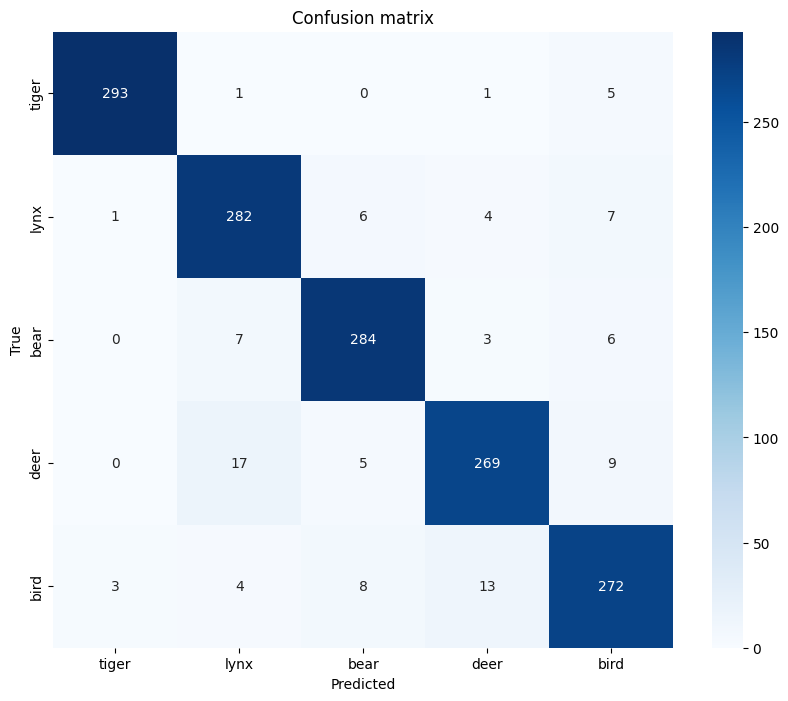

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
confusion_matrix_path = media_dir + '/confusion_matrix.png'
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
plt.show()

## Log run to W&B

In [24]:
run = wandb.init(
    project='tiger_classification',
    config={
        'model_constructor': model_constructor,
        'model_params': model_params,
        'frozen_file_size': frozen_file_size,
        'num_classes': num_classes,
        'n_train_images': n_train_images,
        'n_test_images': n_test_images,
        'batch_size': batch_size,
        'epochs': epochs,
    },
)
wandb.log({
    'training_time_mins': training_time_mins,
    'test_accuracy': round(test_accuracy[1], 4),
    'test2_accuracy': round(test2_accuracy[1], 4),
    'precision': round(precision, 4),
    'recall': round(recall, 4),
    'f1': round(f1, 4),
})
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alexvmt. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.7
wandb: Run data is saved locally in /wandb/run-20241206_221634-2to4ndsg
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficient-fire-9
wandb: ⭐️ View project at https://wandb.ai/alexvmt/tiger_classification
wandb: 🚀 View run at https://wandb.ai/alexvmt/tiger_classification/runs/2to4ndsg
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                 f1 ▁
wandb:          precision ▁
wandb:             recall ▁
wandb:     test2_accuracy ▁
wandb:      test_accuracy ▁
wandb: training_time_mins ▁
wandb: 
wandb: Run summary:
wandb:                 f1 0.9333
wandb:          precision 0.9336
wandb:             recall 0.9333
wandb:     test2_accuracy 0.8713
wandb: